In [1]:
import os
import string
from collections import Counter
from datetime import datetime

import nltk
import pandas as pd
import matplotlib
import seaborn as sns
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.util import ngrams

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.max_open_warning'] = 1000
matplotlib.rcParams['lines.linewidth'] = 1.0

pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Preparing data

In [3]:
original_keywords = ["Picard", "Kirk", "Sulu", "Uhura", "Spock", "McCoy", "Bones", "Scotty", "Chekhov", "Crusher", "Nurse Chapel", "Sarek", "Nero", "Khan", "Data", "Pike", "Star Trek", "Klingon", "Vulcan", "Romulan", "Star fleet", "Starship Enterprise", "Delta Vega", "Earth", "Orion", "Romulan Narada", "Stardate", "Transporter beam", "Beam me up,\? Scotty", "Kobayashi Maru", "Space,\? The Final Frontier", "Energize", "Vulcan Salute", "Prime Directive", "Live long and prosper", "LLAP", "I'm a doctor,\? not a", "KHAAA\+N", "When you eliminate the impossible,\? whatever remains,\? however improbable,\? must be the truth", "Without followers,\? evil cannot spread", "The needs of the many outweigh the needs of the few", "Highly illogical", "to boldly go where no man has gone before", "I'm giving her all she's got,\? Captain", "Nuclear wessels", "Set phasers to stun", "Resistance is futile", "I have been and always shall be your friend"]

In [4]:
print(original_keywords)

['Picard', 'Kirk', 'Sulu', 'Uhura', 'Spock', 'McCoy', 'Bones', 'Scotty', 'Chekhov', 'Crusher', 'Nurse Chapel', 'Sarek', 'Nero', 'Khan', 'Data', 'Pike', 'Star Trek', 'Klingon', 'Vulcan', 'Romulan', 'Star fleet', 'Starship Enterprise', 'Delta Vega', 'Earth', 'Orion', 'Romulan Narada', 'Stardate', 'Transporter beam', 'Beam me up,\\? Scotty', 'Kobayashi Maru', 'Space,\\? The Final Frontier', 'Energize', 'Vulcan Salute', 'Prime Directive', 'Live long and prosper', 'LLAP', "I'm a doctor,\\? not a", 'KHAAA\\+N', 'When you eliminate the impossible,\\? whatever remains,\\? however improbable,\\? must be the truth', 'Without followers,\\? evil cannot spread', 'The needs of the many outweigh the needs of the few', 'Highly illogical', 'to boldly go where no man has gone before', "I'm giving her all she's got,\\? Captain", 'Nuclear wessels', 'Set phasers to stun', 'Resistance is futile', 'I have been and always shall be your friend']


In [5]:
ambiguous_keywords = [
    'Bones',
    'Khan',
    'Data',
    'Earth',
    'Energize',
]

In [6]:
keywords = list(set(original_keywords).difference(ambiguous_keywords))
keywords.sort()

In [7]:
print(keywords)

['Beam me up,\\? Scotty', 'Chekhov', 'Crusher', 'Delta Vega', 'Highly illogical', 'I have been and always shall be your friend', "I'm a doctor,\\? not a", "I'm giving her all she's got,\\? Captain", 'KHAAA\\+N', 'Kirk', 'Klingon', 'Kobayashi Maru', 'LLAP', 'Live long and prosper', 'McCoy', 'Nero', 'Nuclear wessels', 'Nurse Chapel', 'Orion', 'Picard', 'Pike', 'Prime Directive', 'Resistance is futile', 'Romulan', 'Romulan Narada', 'Sarek', 'Scotty', 'Set phasers to stun', 'Space,\\? The Final Frontier', 'Spock', 'Star Trek', 'Star fleet', 'Stardate', 'Starship Enterprise', 'Sulu', 'The needs of the many outweigh the needs of the few', 'Transporter beam', 'Uhura', 'Vulcan', 'Vulcan Salute', 'When you eliminate the impossible,\\? whatever remains,\\? however improbable,\\? must be the truth', 'Without followers,\\? evil cannot spread', 'to boldly go where no man has gone before']


In [8]:
%%time

dtypes = {
    'author': str,
    'body': str,
    'controversiality': str,
    'created_utc': pd.tslib.Timestamp,
    'distinguished': str,
    'downs': str,
    'gilded': str,
    'id': str,
    'name': str,
    'parent_id': str,
    'score': str,
    'subreddit': str,
    'ups': str,
    'month': pd.tslib.Timestamp,
    'year': pd.tslib.Timestamp,
}

reddit_df = pd.read_csv('reddit.csv', header=0, dtype=dtypes, parse_dates=['created_utc', 'month', 'year'])
reddit_df = reddit_df.fillna('')

CPU times: user 28.6 s, sys: 1.24 s, total: 29.8 s
Wall time: 29.8 s


In [9]:
len(reddit_df)

2669814

In [10]:
reddit_df.head()

,author,body,controversiality,created_utc,distinguished,downs,gilded,id,name,parent_id,score,subreddit,ups,month,year
0,gschizas,same in greek. my personal peeve: quite a lot ...,0,2007-10-15 15:22:33,,0.0,0,c029c79,t1_c029c79,t1_c029brz,13,programming,13,2007-10-01,2007-01-01
1,[deleted],&gt;they also decided to rig a thermal barrier...,0,2007-10-16 05:11:09,,0.0,0,c029g6h,t1_c029g6h,t3_5ye94,2,programming,2,2007-10-01,2007-01-01
2,johnmudd,&gt; by the time a child born today graduates ...,0,2007-10-16 07:00:36,,0.0,0,c029gfc,t1_c029gfc,t3_5ye9w,1,science,1,2007-10-01,2007-01-01
3,feliniti,nero 8 - bloated waste of money. unless you ha...,0,2007-10-16 07:10:27,,0.0,0,c029gge,t1_c029gge,t3_5yej4,1,reddit.com,1,2007-10-01,2007-01-01
4,masklinn,&gt; i wonder what happens if you started clea...,0,2007-10-16 11:27:15,,0.0,0,c029hiy,t1_c029hiy,t1_c029h3y,3,reddit.com,3,2007-10-01,2007-01-01


# Analyzing data

## Subreddits

In [12]:
reddit_df['subreddit'].nunique()

24076

In [13]:
reddit_df['subreddit'].value_counts()

AdviceAnimals            216848
startrek                 182534
AskReddit                179550
fantasyfootball           92045
movies                    65545
nfl                       62410
Smite                     58973
DaystromInstitute         57314
sto                       44103
funny                     37788
doctorwho                 35282
pics                      35054
scifi                     33434
Planetside                27387
todayilearned             25934
GlobalOffensiveTrade      25360
motorcycles               24585
SquaredCircle             20231
Civcraft                  19555
IAmA                      18502
gaming                    18339
atheism                   18110
grandorder                16730
chicagobulls              16501
videos                    16271
nba                       16193
PercyJacksonRP            15635
CFB                       15368
WTF                       13752
TheDescendantsOfRome      13213
                          ...  
TrueFals

## Global variables

In [21]:
valid_dates = pd.date_range('2007-10-1', '2016-08-31', freq='MS')

In [181]:
P = 10

## AdviceAnimals

In [26]:
subreddit = 'AdviceAnimals'

peaks = ['2010-12-01', '2012-09-01', '2013-04-01', '2013-07-01', '2013-12-01', '2014-03-01',]
peaks = list(map(pd.lib.Timestamp, peaks))

title = 'Number of comments on subreddit \'' + subreddit + '\' by month'

In [27]:
%%time

subreddit_df = reddit_df[reddit_df['subreddit'] == subreddit]

CPU times: user 315 ms, sys: 4.17 ms, total: 319 ms
Wall time: 316 ms


In [28]:
len(subreddit_df)

216848

In [18]:
subreddit_by_month = pd.Series(subreddit_df.groupby('month')['id'].count())
subreddit_by_month.index.name = None

In [29]:
show_dates = [x.strftime('%Y %b') if x in peaks else '' for x in valid_dates]

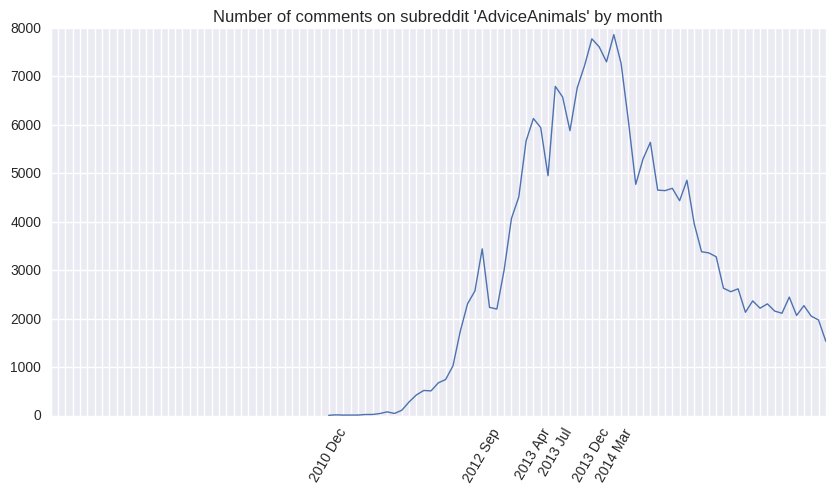

In [30]:
ax = subreddit_by_month.plot(
    figsize=(10, 5),
    xlim=('2007-10-01', '2016-08-31'),
    xticks=valid_dates,
    rot=60,
    title=title,
)
ax.set_xticklabels(show_dates);

### Keywords

In [203]:
peaks

[Timestamp('2010-12-01 00:00:00'),
 Timestamp('2012-09-01 00:00:00'),
 Timestamp('2013-04-01 00:00:00'),
 Timestamp('2013-07-01 00:00:00'),
 Timestamp('2013-12-01 00:00:00'),
 Timestamp('2014-03-01 00:00:00')]

In [207]:
python_instruction = ""
python_instruction += "subreddit_peaks_df = subreddit_df["
for p in peaks:
    python_instruction += "(subreddit_df['month'] == '" + p.strftime('%Y-%m-%d') + "') | "
python_instruction = python_instruction[:-3]
python_instruction += "]"

In [208]:
exec(python_instruction)

In [213]:
subreddit_peaks_df.head()

,author,body,controversiality,created_utc,distinguished,downs,gilded,id,name,parent_id,score,subreddit,ups,month,year
69263,sierrabravo1984,so true.,0,2010-12-11 13:00:12,,0.0,0,c18ol7y,t1_c18ol7y,t3_ek4qf,3,AdviceAnimals,3,2010-12-01,2010-01-01
71324,EvanConover,humans count as animals too!,0,2010-12-21 23:59:30,,0.0,0,c19y4zn,t1_c19y4zn,t1_c19y3nh,2,AdviceAnimals,2,2010-12-01,2010-01-01
71388,EvanConover,"well you get to see it again, you whiner!",0,2010-12-22 11:46:51,,0.0,0,c19zsi6,t1_c19zsi6,t1_c19z5ke,1,AdviceAnimals,1,2010-12-01,2010-01-01
71513,Granite-M,"no, wait! i also like star trek... er... star ...",0,2010-12-23 00:47:45,,0.0,0,c1a2ndz,t1_c1a2ndz,t3_eq87v,20,AdviceAnimals,20,2010-12-01,2010-01-01
72506,sierrabravo1984,why is this in r/adviceanimals?,0,2010-12-29 14:44:36,,0.0,0,c1aqql6,t1_c1aqql6,t3_et2lq,1,AdviceAnimals,1,2010-12-01,2010-01-01


In [11]:
%%time

text_ = ''
for x in subreddit_peaks_df['body']:
    text_ += x + ' '

list_ = [
    w
    for w in nltk.word_tokenize(text_)
    if w not in stopwords.words('english') and w not in string.punctuation
]

counter_ = Counter(list_)

In [ ]:
counter_.most_common(20)

### Sentiment analysis

- The polarity score is a float within the range [-1.0, 1.0].
- The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [31]:
peaks

[Timestamp('2010-12-01 00:00:00'),
 Timestamp('2012-09-01 00:00:00'),
 Timestamp('2013-04-01 00:00:00'),
 Timestamp('2013-07-01 00:00:00'),
 Timestamp('2013-12-01 00:00:00'),
 Timestamp('2014-03-01 00:00:00')]

#### 2012-09-01

In [55]:
date = '2012-09-01'

In [56]:
subreddit_date_df = subreddit_df[subreddit_df['month'] == date]

In [57]:
len(subreddit_date_df)

3441

In [58]:
%%time

sentiment_list = []
for x in subreddit_date_df['body']:
    tb = TextBlob(x)
    sentiment_list.append((x, tb.sentiment.polarity, tb.sentiment.subjectivity))

CPU times: user 1.83 s, sys: 0 ns, total: 1.83 s
Wall time: 1.82 s


In [59]:
sentiment_df = pd.DataFrame(sentiment_list, columns=['body', 'sentiment', 'subjectivity'])

In [60]:
sentiment_df.head()

,body,sentiment,subjectivity
0,it's not the potus's job...until the potus is ...,-0.16,0.65
1,my birthday is 9 months and 9 days after my mo...,0.00,0.00
2,my moms like this. she dosent think homosexual...,0.18,0.38
3,wat?,0.00,0.00
4,what is the inconsistency? if you take romney...,0.64,0.71


In [61]:
sentiment_df['sentiment'].mean()

0.014110222352697552

In [62]:
sentiment_df['subjectivity'].mean()

0.39584458978267406

##### Histogram top positive

In [81]:
P = 1

In [88]:
top_df = sentiment_df.sort_values('sentiment', ascending=False)[:len(subreddit_date_df) * P // 100]

In [89]:
top_df

,body,sentiment,subjectivity
2834,"my girlfriend just got them. yes, they are awe...",1.00,1.00
1792,nsfw? best i can do is some chocolate milk,1.00,0.30
1274,no kidding. it's a perfect storm.,1.00,1.00
650,oh god that was awesome.,1.00,1.00
2639,and we don't care about soccer. usa usa usa us...,1.00,0.40
427,fact: all the best star trek captains are shak...,1.00,0.30
825,best show ever,1.00,0.30
1286,you're awesome.,1.00,1.00
1837,welcome to /r/stopsmoking!,1.00,0.90
1575,best picard ever,1.00,0.30


In [90]:
%%time

top_text = ''
for x in top_df['body']:
    top_text += x + ' '

top_list = [
    w
    for w in nltk.word_tokenize(top_text)
    if w not in stopwords.words('english') and w not in string.punctuation
]

CPU times: user 61.4 ms, sys: 4.13 ms, total: 65.6 ms
Wall time: 64.2 ms


In [85]:
top_counter = Counter(top_list)

In [86]:
top_counter.most_common(20)

[('best', 7),
 ('usa', 6),
 ("n't", 6),
 ('lol', 5),
 ('awesome', 4),
 ("'s", 3),
 ('good', 3),
 ('great', 3),
 ('shall', 2),
 ('years', 2),
 ('mac', 2),
 ('child', 2),
 ('10', 2),
 ('amount', 2),
 ('need', 2),
 ('wo', 2),
 ('girlfriend', 2),
 ('welcome', 2),
 ('like', 2),
 ('made', 2)]

##### Histogram top negative

In [91]:
P = 1

In [92]:
top_df = sentiment_df.sort_values('sentiment', ascending=True)[:len(subreddit_date_df) * P // 100]

In [93]:
top_df

,body,sentiment,subjectivity
2706,why that was just horrible..,-1.00,1.00
690,"wait, my bad, sulu does have the squinty eyes....",-1.00,0.67
1906,unless he has evil daughters.,-1.00,1.00
2923,let the toddler try aeroplane food... after he...,-1.00,0.86
2477,its terrible.,-1.00,1.00
1362,jebus let's hope you're not an atheist. getti...,-1.00,1.00
3364,as a delivery driver this is the worst. also a...,-1.00,1.00
1754,dude and now russia is planning a moon base pr...,-0.90,1.00
241,i thought you guys hated kanye?,-0.90,0.70
617,ooooh sick burn bro!,-0.89,0.86


In [94]:
%%time

top_text = ''
for x in top_df['body']:
    top_text += x + ' '

top_list = [
    w
    for w in nltk.word_tokenize(top_text)
    if w not in stopwords.words('english') and w not in string.punctuation
]

CPU times: user 71.3 ms, sys: 3.91 ms, total: 75.2 ms
Wall time: 74.6 ms


In [95]:
top_counter = Counter(top_list)

In [96]:
top_counter.most_common(20)

[('bad', 18),
 ("n't", 11),
 ('...', 5),
 ('feel', 5),
 ('hate', 4),
 ('stupid', 4),
 ('people', 4),
 ('even', 3),
 ('let', 3),
 ('post', 3),
 ('sick', 3),
 ('like', 2),
 ("'s", 2),
 ('moon', 2),
 ('star', 2),
 ('time', 2),
 ('base', 2),
 ("'re", 2),
 ('thought', 2),
 ('guys', 2)]

In [31]:
peaks

[Timestamp('2010-12-01 00:00:00'),
 Timestamp('2012-09-01 00:00:00'),
 Timestamp('2013-04-01 00:00:00'),
 Timestamp('2013-07-01 00:00:00'),
 Timestamp('2013-12-01 00:00:00'),
 Timestamp('2014-03-01 00:00:00')]

#### 2013-04-01

In [97]:
date = '2013-04-01'

In [98]:
subreddit_date_df = subreddit_df[subreddit_df['month'] == date]

In [99]:
len(subreddit_date_df)

6132

In [100]:
%%time

sentiment_list = []
for x in subreddit_date_df['body']:
    tb = TextBlob(x)
    sentiment_list.append((x, tb.sentiment.polarity, tb.sentiment.subjectivity))

CPU times: user 2.01 s, sys: 0 ns, total: 2.01 s
Wall time: 2.01 s


In [101]:
sentiment_df = pd.DataFrame(sentiment_list, columns=['body', 'sentiment', 'subjectivity'])

In [102]:
sentiment_df.head()

,body,sentiment,subjectivity
0,i know how you feel. it makes you just want to...,0.00,0.00
1,**[no we won't go back!](http://www.youtube.co...,0.00,0.00
2,**captain kirk** - &gt;* as a drunk robot - &g...,0.15,1.00
3,got tired of telling people what the proper me...,-0.18,0.39
4,you ruined the fun.,0.30,0.20


In [103]:
sentiment_df['sentiment'].mean()

0.018057327187746337

In [104]:
sentiment_df['subjectivity'].mean()

0.38495748822681009

##### Histogram top positive

In [105]:
P = 1

In [106]:
top_df = sentiment_df.sort_values('sentiment', ascending=False)[:len(subreddit_date_df) * P // 100]

In [107]:
top_df

,body,sentiment,subjectivity
1775,"when used correctly, confession bear can be fu...",1.00,1.00
6105,quick! someone grab the fire! kill it with fir...,1.00,0.50
2677,&gt;doesn't want kids - - deal breaker there....,1.00,0.30
2001,i try my best.,1.00,0.30
5050,i think it's the perfect date for that.,1.00,1.00
1862,grandma always knows best,1.00,0.30
5493,"best part is, we leave a trace of our team nam...",1.00,0.30
1112,best bullshit i've seen today. well done!,1.00,0.30
2942,indeed. perfectly describes my room.,1.00,1.00
1177,"in all fairness, the extended picard monologue...",1.00,0.30


In [108]:
%%time

top_text = ''
for x in top_df['body']:
    top_text += x + ' '

top_list = [
    w
    for w in nltk.word_tokenize(top_text)
    if w not in stopwords.words('english') and w not in string.punctuation
]

CPU times: user 117 ms, sys: 7.74 ms, total: 125 ms
Wall time: 123 ms


In [109]:
top_counter = Counter(top_list)

In [110]:
top_counter.most_common(20)

[('best', 20),
 ("n't", 9),
 ('good', 7),
 ('awesome', 7),
 ("'s", 7),
 ('ever', 5),
 ('...', 5),
 ('one', 5),
 ('lol', 4),
 ('reddit', 4),
 ('picard', 3),
 ('probably', 3),
 ('would', 3),
 ("'ve", 3),
 ('getting', 3),
 ('karma', 3),
 ('luck', 3),
 ('job', 3),
 ("'m", 3),
 ('wonderful', 3)]

##### Histogram top negative

In [111]:
P = 1

In [112]:
top_df = sentiment_df.sort_values('sentiment', ascending=True)[:len(subreddit_date_df) * P // 100]

In [113]:
top_df

,body,sentiment,subjectivity
2117,"""license and registration, chicken fucker!!!!""",-1.00,0.95
5858,this happens to me sometimes. it's the worst w...,-1.00,1.00
5495,it's like the miss universe winner always bein...,-1.00,1.00
4429,"i am 6'6"" and have never even considered this....",-1.00,1.00
4653,op that's terrible,-1.00,1.00
375,this is the worst use of this macro i've ever ...,-1.00,1.00
3110,what if that demographic is evil people?,-1.00,1.00
741,why would i be disgusted by things that turned...,-1.00,1.00
2211,is that the worst she's done? because if she l...,-1.00,1.00
1075,this is honestly disgusting.,-1.00,1.00


In [114]:
%%time

top_text = ''
for x in top_df['body']:
    top_text += x + ' '

top_list = [
    w
    for w in nltk.word_tokenize(top_text)
    if w not in stopwords.words('english') and w not in string.punctuation
]

CPU times: user 139 ms, sys: 8.06 ms, total: 147 ms
Wall time: 145 ms


In [115]:
top_counter = Counter(top_list)

In [116]:
top_counter.most_common(20)

[("'s", 15),
 ('hate', 13),
 ('stupid', 12),
 ("n't", 10),
 ('people', 9),
 ('...', 9),
 ('would', 6),
 ('like', 6),
 ('worst', 6),
 ('fucking', 5),
 ("''", 5),
 ('way', 4),
 ('terrible', 4),
 ('``', 4),
 ("'re", 4),
 ("'ve", 3),
 ('culture', 3),
 ('violent', 3),
 ('ever', 3),
 ('idiot', 3)]

In [31]:
peaks

[Timestamp('2010-12-01 00:00:00'),
 Timestamp('2012-09-01 00:00:00'),
 Timestamp('2013-04-01 00:00:00'),
 Timestamp('2013-07-01 00:00:00'),
 Timestamp('2013-12-01 00:00:00'),
 Timestamp('2014-03-01 00:00:00')]

#### 2013-07-01

In [117]:
date = '2013-07-01'

In [118]:
subreddit_date_df = subreddit_df[subreddit_df['month'] == date]

In [119]:
len(subreddit_date_df)

6796

In [120]:
%%time

sentiment_list = []
for x in subreddit_date_df['body']:
    tb = TextBlob(x)
    sentiment_list.append((x, tb.sentiment.polarity, tb.sentiment.subjectivity))

CPU times: user 2.29 s, sys: 67 µs, total: 2.29 s
Wall time: 2.29 s


In [121]:
sentiment_df = pd.DataFrame(sentiment_list, columns=['body', 'sentiment', 'subjectivity'])

In [122]:
sentiment_df.head()

,body,sentiment,subjectivity
0,i guess all the wrist-fetishists took the day ...,0.00,0.00
1,here is what the linked meme says in case it i...,0.01,0.58
2,here is what the linked meme says in case it i...,0.07,0.69
3,google.,0.00,0.00
4,"worked for bruce willis, sean connery, sam l j...",0.00,0.00


In [123]:
sentiment_df['sentiment'].mean()

0.0089380478853607025

In [124]:
sentiment_df['subjectivity'].mean()

0.44067223843100611

##### Histogram top positive

In [125]:
P = 1

In [126]:
top_df = sentiment_df.sort_values('sentiment', ascending=False)[:len(subreddit_date_df) * P // 100]

In [127]:
top_df

,body,sentiment,subjectivity
223,greatest jesus ever.,1.00,1.00
2087,i think the standards for socially awesome is ...,1.00,1.00
833,"the best format for data file naming too, but ...",1.00,0.30
248,happens to the best of us.,1.00,0.30
4706,yess! that is the best episode of extras. pic...,1.00,0.30
3202,"that's perfect, buddy.",1.00,1.00
2623,best thing i've ever seen,1.00,0.30
3959,peanut butter with sliced strawberries is also...,1.00,1.00
6594,almost perfect loop. damnit man,1.00,1.00
6303,"""my opinion is so awesome that everyone should...",1.00,1.00


In [128]:
%%time

top_text = ''
for x in top_df['body']:
    top_text += x + ' '

top_list = [
    w
    for w in nltk.word_tokenize(top_text)
    if w not in stopwords.words('english') and w not in string.punctuation
]

CPU times: user 121 ms, sys: 11.4 ms, total: 133 ms
Wall time: 131 ms


In [129]:
top_counter = Counter(top_list)

In [130]:
top_counter.most_common(20)

[('best', 14),
 ('awesome', 12),
 ('...', 9),
 ('happy', 8),
 ("'s", 7),
 ('great', 7),
 ('would', 6),
 ('``', 5),
 ("'ve", 5),
 ('birthday', 5),
 ("n't", 5),
 ("''", 5),
 ('perfect', 5),
 ('one', 4),
 ('reddit', 4),
 ('ever', 4),
 ('lol', 4),
 ('congratulations', 3),
 ('op', 3),
 ("'re", 3)]

##### Histogram top negative

In [131]:
P = 1

In [132]:
top_df = sentiment_df.sort_values('sentiment', ascending=True)[:len(subreddit_date_df) * P // 100]

In [133]:
top_df

,body,sentiment,subjectivity
3480,"no,humans make the worst people.",-1.00,1.00
421,the comments in this thread are horrible. don'...,-1.00,1.00
1749,it's the worst when wrapping christmas presents.,-1.00,1.00
1954,:'(,-1.00,1.00
4037,terrible.,-1.00,1.00
5485,this is so fucking terrible...,-1.00,1.00
2383,holy crap! you have the ability to send your i...,-1.00,0.80
2662,why would anyone touch a dirt disgusting cat t...,-1.00,1.00
2515,this must be one of the worst uses of this mem...,-1.00,1.00
2420,"uninstall your web browser, you're terrible at...",-1.00,1.00


In [134]:
%%time

top_text = ''
for x in top_df['body']:
    top_text += x + ' '

top_list = [
    w
    for w in nltk.word_tokenize(top_text)
    if w not in stopwords.words('english') and w not in string.punctuation
]

CPU times: user 157 ms, sys: 12.1 ms, total: 169 ms
Wall time: 167 ms


In [135]:
top_counter = Counter(top_list)

In [136]:
top_counter.most_common(20)

[('stupid', 11),
 ("'s", 11),
 ('hate', 10),
 ('...', 10),
 ("n't", 8),
 ('fucking', 7),
 ('annoying', 7),
 ('people', 6),
 ('like', 6),
 ('worst', 6),
 ("'re", 6),
 ('meme', 6),
 ('one', 5),
 ('gt', 5),
 ('terrible', 4),
 ('would', 4),
 ('bad', 4),
 ("''", 4),
 ('``', 4),
 ('get', 3)]

In [31]:
peaks

[Timestamp('2010-12-01 00:00:00'),
 Timestamp('2012-09-01 00:00:00'),
 Timestamp('2013-04-01 00:00:00'),
 Timestamp('2013-07-01 00:00:00'),
 Timestamp('2013-12-01 00:00:00'),
 Timestamp('2014-03-01 00:00:00')]

#### 2013-12-01

In [137]:
date = '2013-12-01'

In [138]:
subreddit_date_df = subreddit_df[subreddit_df['month'] == date]

In [139]:
len(subreddit_date_df)

7777

In [140]:
%%time

sentiment_list = []
for x in subreddit_date_df['body']:
    tb = TextBlob(x)
    sentiment_list.append((x, tb.sentiment.polarity, tb.sentiment.subjectivity))

CPU times: user 2.45 s, sys: 0 ns, total: 2.45 s
Wall time: 2.45 s


In [141]:
sentiment_df = pd.DataFrame(sentiment_list, columns=['body', 'sentiment', 'subjectivity'])

In [142]:
sentiment_df.head()

,body,sentiment,subjectivity
0,to went through 2 bottles of big horse pill vi...,0.09,0.45
1,popular on reddit =\= popular in general. - s...,0.34,0.71
2,mine was not minimal - - all four completely ...,0.04,0.23
3,this guy,0.00,0.00
4,i laughed *way* too hard at this.,0.20,0.37


In [143]:
sentiment_df['sentiment'].mean()

0.029342055587012812

In [144]:
sentiment_df['subjectivity'].mean()

0.40783370127326213

##### Histogram top positive

In [145]:
P = 1

In [146]:
top_df = sentiment_df.sort_values('sentiment', ascending=False)[:len(subreddit_date_df) * P // 100]

In [147]:
top_df

,body,sentiment,subjectivity
2722,you can buy stuff from [my shop](http://www.et...,1.00,1.00
7582,thinking waving and smiling at a girl is socia...,1.00,1.00
6640,that is the best analogy for anything i have e...,1.00,0.30
672,the perfect comeback.,1.00,1.00
5953,best picard meme ever.,1.00,0.30
5211,"i think there's a misconception going on here,...",1.00,1.00
257,you. are. awesome for linking those.,1.00,1.00
7677,just affirmimg headblade is awesome.,1.00,1.00
5926,"&gt; in hindsight, telling him to get off my c...",1.00,0.65
4271,"i would be pissed off by somebody saying: ""hap...",1.00,1.00


In [148]:
%%time

top_text = ''
for x in top_df['body']:
    top_text += x + ' '

top_list = [
    w
    for w in nltk.word_tokenize(top_text)
    if w not in stopwords.words('english') and w not in string.punctuation
]

CPU times: user 148 ms, sys: 8.12 ms, total: 156 ms
Wall time: 154 ms


In [149]:
top_counter = Counter(top_list)

In [150]:
top_counter.most_common(20)

[('best', 15),
 ('awesome', 12),
 ('great', 9),
 ("n't", 8),
 ("'s", 8),
 ('lol', 7),
 ('...', 6),
 ('good', 6),
 ('happy', 5),
 ('ever', 5),
 ('well', 4),
 ('shower', 4),
 ('get', 4),
 ("''", 4),
 ('``', 4),
 ('perfect', 4),
 ('welcome', 4),
 ('http', 4),
 ('brave', 4),
 ('want', 3)]

##### Histogram top negative

In [151]:
P = 1

In [152]:
top_df = sentiment_df.sort_values('sentiment', ascending=True)[:len(subreddit_date_df) * P // 100]

In [153]:
top_df

,body,sentiment,subjectivity
1121,i'm disgusted. take your upvote and go.,-1.00,1.00
3721,the lust for karma is a cruel mistress.,-1.00,1.00
1759,i would go insane.,-1.00,1.00
3109,disgusting,-1.00,1.00
3517,:'(,-1.00,1.00
7452,"god, this is terrible...",-1.00,1.00
2218,i would always get ice caps at tim horton's in...,-1.00,1.00
6011,you fail captionbot!!!!,-1.00,0.30
5757,horrible responses?,-1.00,1.00
5182,what a shocking confession!,-1.00,1.00


In [154]:
%%time

top_text = ''
for x in top_df['body']:
    top_text += x + ' '

top_list = [
    w
    for w in nltk.word_tokenize(top_text)
    if w not in stopwords.words('english') and w not in string.punctuation
]

CPU times: user 153 ms, sys: 7.72 ms, total: 161 ms
Wall time: 160 ms


In [155]:
top_counter = Counter(top_list)

In [156]:
top_counter.most_common(20)

[("n't", 14),
 ('hate', 14),
 ('...', 13),
 ("'s", 11),
 ('stupid', 7),
 ('know', 6),
 ('people', 6),
 ('fucking', 5),
 ("'m", 5),
 ('get', 4),
 ('would', 4),
 ('like', 4),
 ('crap', 4),
 ('go', 4),
 ('rarr', 4),
 ('got', 3),
 ('one', 3),
 ('horrible', 3),
 ('kids', 3),
 ('http', 3)]

In [31]:
peaks

[Timestamp('2010-12-01 00:00:00'),
 Timestamp('2012-09-01 00:00:00'),
 Timestamp('2013-04-01 00:00:00'),
 Timestamp('2013-07-01 00:00:00'),
 Timestamp('2013-12-01 00:00:00'),
 Timestamp('2014-03-01 00:00:00')]

#### 2014-03-01

In [157]:
date = '2014-03-01'

In [158]:
subreddit_date_df = subreddit_df[subreddit_df['month'] == date]

In [159]:
len(subreddit_date_df)

7864

In [160]:
%%time

sentiment_list = []
for x in subreddit_date_df['body']:
    tb = TextBlob(x)
    sentiment_list.append((x, tb.sentiment.polarity, tb.sentiment.subjectivity))

CPU times: user 2.64 s, sys: 0 ns, total: 2.64 s
Wall time: 2.63 s


In [161]:
sentiment_df = pd.DataFrame(sentiment_list, columns=['body', 'sentiment', 'subjectivity'])

In [162]:
sentiment_df.head()

,body,sentiment,subjectivity
0,i do both...,0.00,0.00
1,"i wet the brush, put toothpaste on, then wet i...",-0.23,0.60
2,that's when you look them in the eyes to asser...,0.00,0.00
3,"i wish that any conflict was up to the ""people...",0.50,0.60
4,anal? kissing is cheating...wtf is this chick...,0.00,0.00


In [163]:
sentiment_df['sentiment'].mean()

0.038250934513096413

In [164]:
sentiment_df['subjectivity'].mean()

0.40859762511820785

##### Histogram top positive

In [165]:
P = 1

In [166]:
top_df = sentiment_df.sort_values('sentiment', ascending=False)[:len(subreddit_date_df) * P // 100]

In [168]:
top_df

,body,sentiment,subjectivity
1507,"make it so, and ensign, have that delightful d...",1.00,1.00
5049,[best i can do](http://i.imgur.com/kyns5ql.gif),1.00,0.30
1448,bucky larson is your roommate? awesome,1.00,1.00
5385,i'm hoping you heard this fable from star trek...,1.00,1.00
6177,you're an awesome person. the fact that this m...,1.00,1.00
2693,(music note) everything is awesome when you're...,1.00,1.00
6594,welcome to the internet!,1.00,0.90
4950,you have not seen the things we maintenance wo...,1.00,1.00
5463,best bot ever.,1.00,0.30
299,its the best lubricant!,1.00,0.30


In [169]:
%%time

top_text = ''
for x in top_df['body']:
    top_text += x + ' '

top_list = [
    w
    for w in nltk.word_tokenize(top_text)
    if w not in stopwords.words('english') and w not in string.punctuation
]

CPU times: user 175 ms, sys: 4.13 ms, total: 179 ms
Wall time: 178 ms


In [170]:
top_counter = Counter(top_list)

In [171]:
top_counter.most_common(20)

[('best', 21),
 ("'s", 12),
 ('awesome', 11),
 ('good', 10),
 ("'re", 9),
 ("n't", 7),
 ('perfect', 7),
 ('...', 6),
 ('great', 6),
 ('``', 5),
 ("''", 5),
 ('seen', 4),
 ('post', 4),
 ('like', 4),
 ('ever', 4),
 ('time', 4),
 ('people', 4),
 ('want', 3),
 ('way', 3),
 ('man', 3)]

##### Histogram top negative

In [175]:
P = 1

In [176]:
top_df = sentiment_df.sort_values('sentiment', ascending=True)[:len(subreddit_date_df) * P // 100]

In [177]:
top_df

,body,sentiment,subjectivity
7570,maybe she's just terrible in bed...,-1.00,1.00
7122,star trek is the worst at this.,-1.00,1.00
3796,probably because some people hide the fact tha...,-1.00,1.00
1924,i think downvoting people and not explaining w...,-1.00,1.00
3829,i change the channel or leave the room. my wif...,-1.00,1.00
5946,dae hate faux?!?,-1.00,0.90
854,itt: people who do this trying to justify thei...,-1.00,1.00
1527,"its being distracted, and as someone whos teac...",-1.00,1.00
630,fuck!!!!!!!!!!!!!!!!!!!!,-1.00,0.60
6192,you know not of which you speak. - - i've liv...,-1.00,1.00


In [178]:
%%time

top_text = ''
for x in top_df['body']:
    top_text += x + ' '

top_list = [
    w
    for w in nltk.word_tokenize(top_text)
    if w not in stopwords.words('english') and w not in string.punctuation
]

CPU times: user 206 ms, sys: 8.39 ms, total: 214 ms
Wall time: 212 ms


In [179]:
top_counter = Counter(top_list)

In [180]:
top_counter.most_common(20)

[("n't", 14),
 ("'s", 14),
 ('stupid', 11),
 ('hate', 11),
 ('idiot', 10),
 ("''", 9),
 ('get', 8),
 ('even', 8),
 ('one', 8),
 ('...', 8),
 ("'m", 7),
 ('``', 7),
 ("'re", 6),
 ('terrible', 5),
 ('fucking', 5),
 ('know', 5),
 ('worst', 4),
 ('think', 4),
 ('hated', 4),
 ('people', 4)]

## startrek

In [14]:
subreddit = 'startrek'

peaks = ['2009-05-01', '2012-12-01', '2013-05-01', '2016-07-01',]
peaks = list(map(pd.lib.Timestamp, peaks))

title = 'Number of comments on subreddit \'' + subreddit + '\' by month'

In [15]:
%%time

subreddit_df = reddit_df[reddit_df['subreddit'] == subreddit]

CPU times: user 288 ms, sys: 104 ms, total: 392 ms
Wall time: 390 ms


In [16]:
len(subreddit_df)

182534

In [17]:
subreddit_by_month = pd.Series(subreddit_df.groupby('month')['id'].count())
subreddit_by_month.index.name = None

In [18]:
show_dates = [x.strftime('%Y %b') if x in peaks else '' for x in valid_dates]

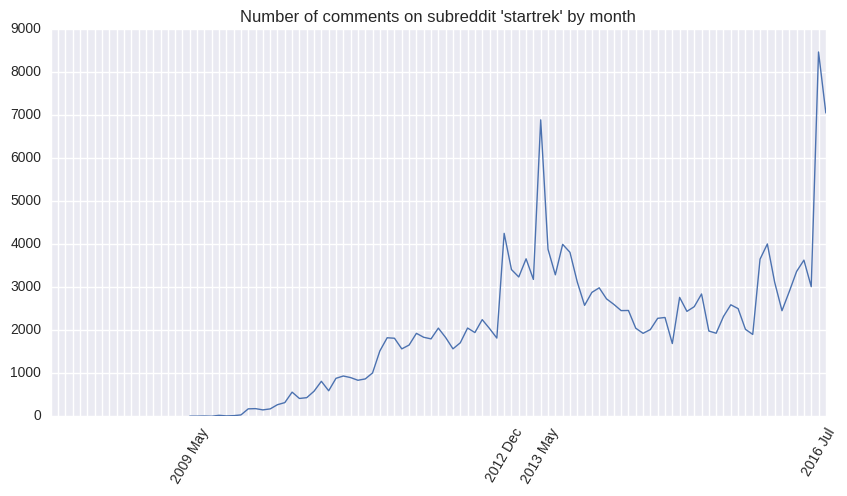

In [19]:
ax = subreddit_by_month.plot(
    figsize=(10, 5),
    xlim=('2007-10-01', '2016-08-31'),
    xticks=valid_dates,
    rot=60,
    title=title,
)
ax.set_xticklabels(show_dates);

### Sentiment analysis

- The polarity score is a float within the range [-1.0, 1.0].
- The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [20]:
peaks

[Timestamp('2009-05-01 00:00:00'),
 Timestamp('2012-12-01 00:00:00'),
 Timestamp('2013-05-01 00:00:00'),
 Timestamp('2016-07-01 00:00:00')]

#### 2012-12-01

In [21]:
date = '2012-12-01'

In [22]:
subreddit_date_df = subreddit_df[subreddit_df['month'] == date]

In [23]:
len(subreddit_date_df)

4250

In [24]:
%%time

sentiment_list = []
for x in subreddit_date_df['body']:
    tb = TextBlob(x)
    sentiment_list.append((x, tb.sentiment.polarity, tb.sentiment.subjectivity))

CPU times: user 2.93 s, sys: 16.1 ms, total: 2.94 s
Wall time: 2.94 s


In [25]:
sentiment_df = pd.DataFrame(sentiment_list, columns=['body', 'sentiment', 'subjectivity'])

In [26]:
sentiment_df.head()

,body,sentiment,subjectivity
0,"not when the motto of all klingon comics is: ""...",0.70,0.60
1,sulu didn't have a japanese accent. he's from...,0.00,0.00
2,"i've always been a fan of the ""everything in l...",0.17,0.35
3,uber star wars fan here.... i would love to ha...,0.62,0.60
4,how could you forget klingon academy,0.00,0.00


In [27]:
sentiment_df['sentiment'].mean()

0.10905434748800666

In [28]:
sentiment_df['sentiment'].std()

0.22151434367769657

In [29]:
sentiment_df['subjectivity'].mean()

0.45640362011347496

In [30]:
sentiment_df['subjectivity'].std()

0.23485023480906297

#### 2013-05-01

In [31]:
date = '2013-05-01'

In [32]:
subreddit_date_df = subreddit_df[subreddit_df['month'] == date]

In [33]:
len(subreddit_date_df)

6886

In [34]:
%%time

sentiment_list = []
for x in subreddit_date_df['body']:
    tb = TextBlob(x)
    sentiment_list.append((x, tb.sentiment.polarity, tb.sentiment.subjectivity))

CPU times: user 4.69 s, sys: 0 ns, total: 4.69 s
Wall time: 4.68 s


In [35]:
sentiment_df = pd.DataFrame(sentiment_list, columns=['body', 'sentiment', 'subjectivity'])

In [36]:
sentiment_df.head()

,body,sentiment,subjectivity
0,"holy moire, kirk!",0.00,0.00
1,abrams' movie is easily one of the best trek m...,0.61,0.61
2,"guys guys guys, new star trek is good. old (tn...",0.21,0.30
3,"eh, there's some good one-off ones. i really l...",0.40,0.61
4,"i don't think he's ""overacting"", at least as f...",-0.02,0.48


In [37]:
sentiment_df['sentiment'].mean()

0.11140917678554957

In [38]:
sentiment_df['sentiment'].std()

0.2179435356519433

In [39]:
sentiment_df['subjectivity'].mean()

0.46197876374164276

In [40]:
sentiment_df['subjectivity'].std()

0.22817620986639806

#### 2016-07-01

In [41]:
date = '2016-07-01'

In [42]:
subreddit_date_df = subreddit_df[subreddit_df['month'] == date]

In [43]:
len(subreddit_date_df)

8462

In [44]:
%%time

sentiment_list = []
for x in subreddit_date_df['body']:
    tb = TextBlob(x)
    sentiment_list.append((x, tb.sentiment.polarity, tb.sentiment.subjectivity))

CPU times: user 6.17 s, sys: 76 µs, total: 6.17 s
Wall time: 6.16 s


In [45]:
sentiment_df = pd.DataFrame(sentiment_list, columns=['body', 'sentiment', 'subjectivity'])

In [46]:
sentiment_df.head()

,body,sentiment,subjectivity
0,vulcan women would not wear uncomfortable shoes.,-0.50,1.00
1,then i wouldn't bother. - - i love the origin...,0.15,0.41
2,he's done it for a few lines in the previous m...,-0.03,0.27
3,yes! still a great series! - - it was old wh...,0.15,0.47
4,beam me up scotty.,0.00,0.00


In [47]:
sentiment_df['sentiment'].mean()

0.10954424826620877

In [48]:
sentiment_df['sentiment'].std()

0.21422561804654525

In [49]:
sentiment_df['subjectivity'].mean()

0.46977461486056721

In [50]:
sentiment_df['subjectivity'].std()

0.21940826297514379